# **Kenya Housing Value Details**

Among the worst hit sectors due to Covid-19 was the real estate. According to the data provided by the [Kenya Property Center](https://kenyapropertycentre.com/market-trends/average-prices), Nairobi tops the list of county with an average high of KSh 70,000 per month in rental houses followed by Mombasa and Kilifi with an average of KSh 40,000 per month. Based on towns, Lavington, Karen, an Westlands top the list with an average monthly rental charges of KSh 210K, KSh 150K, and 130K respectively. The dataset of interest is obtained [here](https://www.kaggle.com/datasets/iamasteriix/rental-apartments-in-kenya).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
from scipy.stats import norm, t, levene
import pingouin

apt_rents = pd.read_csv('rent_apts.csv')
apt_rents.head()

,Agency,Neighborhood,Price,link,sq_mtrs,Bedrooms,Bathrooms
0,Buy Rent Shelters,"General Mathenge, Westlands","KSh 155,000",/listings/4-bedroom-apartment-for-rent-general...,4.0,4.0,4.0
1,Kenya Classic Homes,"Kilimani, Dagoretti North","KSh 100,000",/listings/3-bedroom-apartment-for-rent-kiliman...,300.0,3.0,4.0
2,Absolute Estate Agents,"Hatheru Rd,, Lavington, Dagoretti North","KSh 75,000",/listings/3-bedroom-apartment-for-rent-lavingt...,3.0,3.0,5.0
3,A1 Properties Limited,"Kilimani, Dagoretti North","KSh 135,000",/listings/3-bedroom-apartment-for-rent-kiliman...,227.0,3.0,4.0
4,Pmc Estates Limited,"Imara Daima, Embakasi","KSh 50,000",/listings/3-bedroom-apartment-for-rent-imara-d...,3.0,3.0,NaN


# **Data Cleaning & Selection** 

From the data, the variables of interest are Neighborhood, Price, House size (sq_mtrs), number of bedrooms and bathrooms. However, before analysis, some cleaning is in order. As a starting point, only two variables will be considered$-$`Neighborhood` and `Price`. The remaining adjustments will be considered as analysis goes by.

In [2]:
apt_rents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        1848 non-null   object 
 1   Neighborhood  1848 non-null   object 
 2   Price         1848 non-null   object 
 3   link          1848 non-null   object 
 4   sq_mtrs       1846 non-null   float64
 5   Bedrooms      1845 non-null   float64
 6   Bathrooms     1557 non-null   float64
dtypes: float64(3), object(4)
memory usage: 101.2+ KB


## Neighborhood

The `Neighborhood` variable contains the location of these houses. A look at these values shows that there are over 600 unique places. However, the interest is on specific locations.

In [3]:
len(apt_rents.Neighborhood.unique())

647

Here, we create a column `region` which we take the last name which most represent constituency with a few exceptions of places like 'Mombasa Rd' among others. Now out of 647 unique Neighborhoods there are only 37 unique neighborhoods stored in the column `region`. Note that whitespace is removed.

In [4]:
get_region = lambda x: x.rpartition(',')[-1]
remove_space = lambda x: x.strip()

apt_rents['region'] = apt_rents.Neighborhood\
                .apply(get_region)\
                .apply(remove_space)

print('number of regions:', len(apt_rents.region.unique()), '\n')
print(apt_rents.region.head())

number of regions: 37 

0          Westlands
1    Dagoretti North
2    Dagoretti North
3    Dagoretti North
4           Embakasi
Name: region, dtype: object


## Rental Prices

The `Price` variables also need some adjustments to convert it from an `Object` data type to integer. To do this the comma and the `KSh` currency symbol are removed.

In [5]:
remove_character = lambda x: x.translate({ord(c): None for c in ",KSh"})

apt_rents['rental_price'] = apt_rents.Price.apply(remove_character)
apt_rents['rental_price'] = apt_rents['rental_price'].astype('int64')

print(apt_rents.rental_price.head())
assert apt_rents.rental_price.dtype == 'int64'

0    155000
1    100000
2     75000
3    135000
4     50000
Name: rental_price, dtype: int64


## Data Selection

The variables `Agency` and `link` won't be of use in this analysis but they provide some useful information to buyers. Onwards, the data for analysis is stored in `rental_aprt` DataFrame.

In [6]:
rental_aprt = apt_rents[['region', 'rental_price', 'sq_mtrs', 'Bedrooms', 'Bathrooms']]
print(rental_aprt.head())

            region  rental_price  sq_mtrs  Bedrooms  Bathrooms
0        Westlands        155000      4.0       4.0        4.0
1  Dagoretti North        100000    300.0       3.0        4.0
2  Dagoretti North         75000      3.0       3.0        5.0
3  Dagoretti North        135000    227.0       3.0        4.0
4         Embakasi         50000      3.0       3.0        NaN


## Further Selection

This analysis will be based on regions. Therefore, to use parametric analysis, each `region` should have about 30 entries across the variables. Going by this assumptions, only 6 regions meet the requirement.

In [7]:
thirty_more = (rental_aprt.region.value_counts() >= 30).sum()
print(f'Count of regions with more than 30 entries: {thirty_more}')

Count of regions with more than 30 entries: 6


Therefore, sub-setting is in order. Here, a list that contains regions with 30 entries across the variables, `thirty_entries` is obtained and then used to subset the DataFrame. Note that the local variable `thirty_more` which was defined previously is used to obtain only the names of regions which met the 30 data entries threshold. It is evident that about 150 of the data entries did not meet the minimum requirement size of 30. 

In [8]:
thirty_entries = rental_aprt.region\
                .value_counts()\
                .index\
                .to_list()[:thirty_more]

rental_aprt = rental_aprt[rental_aprt.region.isin(thirty_entries)]
print(rental_aprt.shape)
print(rental_aprt.head())

(1698, 5)
            region  rental_price  sq_mtrs  Bedrooms  Bathrooms
0        Westlands        155000      4.0       4.0        4.0
1  Dagoretti North        100000    300.0       3.0        4.0
2  Dagoretti North         75000      3.0       3.0        5.0
3  Dagoretti North        135000    227.0       3.0        4.0
5        Westlands        150000      2.0       2.0        NaN


## Handling Missing Values

Checking the missing values it is evident that `Bedrooms` and `sq_mtrs` have 3 and 2 missing values respectively. However, `Bathroom` has a large number of missing values 262.

In [9]:
rental_aprt.isna().sum()

region            0
rental_price      0
sq_mtrs           2
Bedrooms          3
Bathrooms       262
dtype: int64

To handle this, the `region` column is dropped and an imputer used to compute a value for the median number of `sq_mtrs`, `bedrooms`, and `bathrooms`. Median used because it is robust when it comes to outliers. However, the data type is `Object` which presents some challenges during analysis. Therefore, it has to be converted to categorical data.

In [10]:
rental_aprt.fillna(rental_aprt.drop('region', axis=1).median(),\
                   inplace=True)

rental_aprt['region'] = rental_aprt.region.astype('category')
print(rental_aprt.head())

            region  rental_price  sq_mtrs  Bedrooms  Bathrooms
0        Westlands        155000      4.0       4.0        4.0
1  Dagoretti North        100000    300.0       3.0        4.0
2  Dagoretti North         75000      3.0       3.0        5.0
3  Dagoretti North        135000    227.0       3.0        4.0
5        Westlands        150000      2.0       2.0        2.0


# **Z-Score**

## Setting Significance Level

The significance level is set at 0.1. That is, if 10 out of 100 houses are priced at 100K, $H_0$ is accepted or else otherwise. 

In [11]:
alpha = 0.1

## Formulating Hypothesis Statement

The hypothesized average rental prices in these 6 regions is KSh 100K. The value arrived at after finding the median which is robust to variability. Therefore, 

$H_0$: The average house rent price is KSh 100K. 

$H_A$: The average house rent price is higher than KSh 100K because the prices in real estate are currently going up.

In [12]:
hypothesized_price = rental_aprt.rental_price.median()
hypothesized_price

100000.0

## Calculating Point Estimate

Let's begin our analysis by calculating a point estimate (or sample statistic), namely the proportion of rental prices.

In [13]:
sample_price = rental_aprt.rental_price.mean()
sample_price

101368.95936395759

## Computing z-score

The result is different from our hypothesis, but is it meaningfully different? To answer this we'll calculate the z-score. First, a bootstrap sample is generated.

In [14]:
np.random.seed(42)
bootstrap_sample = []

for _ in range(3000):
    bootstrap = np.mean(rental_aprt.rental_price.sample(frac=1, replace=True))
    bootstrap_sample.append(bootstrap)

### Visualzing the Means in Boostrap's Histogram

Let's visualize our sample mean and hypothesized mean in this distribution in the bootstrap sample. Notice that the histogram is bell shaped, hence it's roughly normally distributed. Also, note that the hypothesized average house price
is on the left of the distribution.

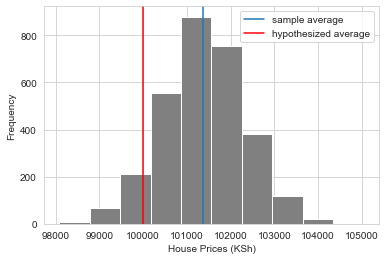

In [15]:
plt.hist(bootstrap_sample, color='grey')
plt.axvline([sample_price], label='sample average')
plt.axvline([hypothesized_price], 
            label='hypothesized average',
            color='r')
plt.xlabel('House Prices (KSh)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Standardization

Before performing a hypothesis test, we need to standardize the rental price values since variables have arbitrary units and ranges. For this hypothesis test, we use the z-score.

$$z = \frac{\text{sample statistics - hypothesized parameter value}}{\text{standard error}}$$

All the values are already present except for the standard error which we'll calculate by getting the standard deviation of the bootstrap sample. After which, we'll substitute them into the equation. 

- Here, the standard error is 1.47. Is this a big or a small number?

In [16]:
std_error = np.std(bootstrap_sample, ddof=1)
z_score = (sample_price - hypothesized_price) / std_error
print(z_score)

1.4662924621401678


## Computing p-Value

p-value quantify how much evidence there is for the acceptance or rejection of the null hypothesis. To compute it, the `z_score` value is passed to the standard normal CDF, `norm.cdf()`, from `scipy.stats`. For now, the defaults are left as they are: mean zero and standard deviation of one. 

- Here, the appropriate test will be a right tailed test. Thus, the p-value is computed by taking one minus the `norm.cdf()` result. 

From the result 7 out of 100 of the houses are priced at 100K. 

In [17]:
p_value = 1 - norm.cdf(z_score)
print(p_value)

0.07128431407028146


## Making Decision

The p-value is less than the alpha value. Therefore, we reject the null hypothesis. Keep in mind that this result could be a false positive (Type I) error. That is, chosing $H_A$ when $H_0$ could be the right choice.

In [18]:
p_value > alpha

False

### Computing the Confidence Interval

Due to sampling variability, sample statistics are bound to be wrong by some amount. Here, the hypothesized value for rental prices is 100K while the calculated was 101K, so it is goo to state the confidence interval. Being that an $\alpha$ of 0.1 was used, the confidence interval of $1 - \alpha$ will be 99%. 

- With a 99% CI, the average rental prices is between KSh 99K and KSh 102K. Therefore, since KSh 101K is included in the 99% CI and we had already rejected $H_0$ due to the small p-value, the confidence interval tells us otherwise. This outcome confirms that indeed there was a Type I error.

In [19]:
lower = np.quantile(bootstrap_sample, 0.05)
upper = np.quantile(bootstrap_sample, 0.95)

lower, upper

(99859.14540636043, 102917.05992343933)

# Two-Sample t-Test

Dagoretti North and Westlands have entries above 600 while the rest have entries below 100. Therefore, the first analysis will focus on the two regions and the second one on the others. 

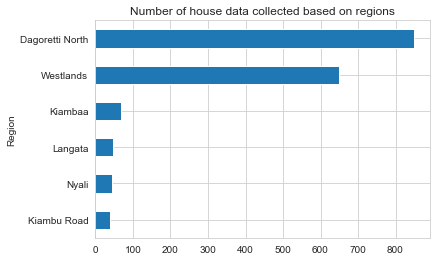

In [20]:
rental_aprt.region\
        .value_counts(ascending=True)\
        .plot(kind='barh', 
              title='Number of house data collected based on regions',
              xlabel='Region')
plt.show()

## Question and Hypotheses

Therefore, the question is:

- "*Are rental prices in Dagoretti North equal to rental prices in Westlands?*"

The null hypothesis is that the overall rental prices is equal in both location, while the alternative hypotheis is that rental price in Dagoretti North is not equal to those in Westlands.

- $H_0: \mu_{\text{Dagoretti North}} - \mu_{\text{Westlands}} = 0$

- $H_A: \mu_{\text{Dagoretti North}} - \mu_{\text{Westlands}} \neq 0$

In [ ]:
west_dago = rental_aprt[(rental_aprt.region=='Westlands')\
                        | (rental_aprt.region == 'Dagoretti North')]
print(west_dago.head())

## Distribution of Variables

Here, the approriate test will be a t-test. A check for normality reveals that rental prices in Westlands follows a normal distribution while in Dagoretti North the distribution is a slightly skewed to the right. 

- For now a t-test will be conducted for both variables. Any adjustment will be made later on. As before, the significance level is set at 0.1

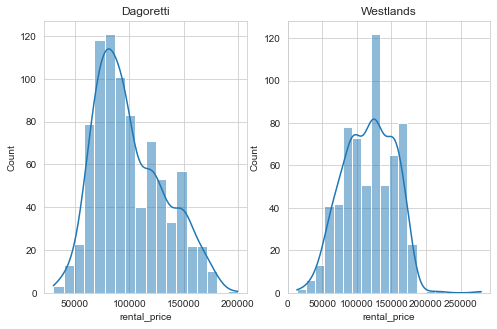

In [55]:
westland = west_dago[west_dago.region == 'Westlands'].rental_price
dagoretti = west_dago[west_dago.region == 'Dagoretti North'].rental_price

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
with sns.axes_style('ticks'):
    sns.histplot(dagoretti, kde=True, ax=ax1)
    sns.histplot(westland, kde=True, ax=ax2)
ax1.set_title('Dagoretti')
ax2.set_title('Westlands');

## Levene's Test

This test tests the null hypothesis that all input samples are from population with equal variance. Here the p-value is less than 0.05 thus we reject the null hypothesis and conclude that the samples comes from population with significant difference in population variance. 

- Being that the p-value of Levene's Test is quite sensitive to sample size, the test is only used for guidance.

In [58]:
levene(dagoretti, westland, 
       center='mean', 
       proportiontocut=0.05)

LeveneResult(statistic=16.011414974093732, pvalue=6.60369888945088e-05)

## Summary Statistics

The summary statistics shows that the average rental prices in Dagoretti North is about 100K while in Westlands it is about 116K. The question is whether this difference is statistically significant or is it as a result of sampling variability.

In [22]:

west_dago.groupby('region')['rental_price'].mean().dropna()

region
Dagoretti North    100124.705882
Westlands          116943.835385
Name: rental_price, dtype: float64

## Calculating Test Statistics and p-Value

Assuming that null hypothesis is true, $t$ is given by the equation: 

$$t = \frac{(\bar{x}_{\text{Dago}} - \bar{x}_{\text{Westy}})}{\sqrt{\frac{s^2_{\text{Dago}}}{n_{\text{Dago}}} + \frac{s^2_{\text{Westy}}}{n_{\text{Westy}}}}}$$

Being that this is a two sided t-test, we'll use the `pingouin` package to calculate the t statistics and other results. Note that this is not an independent test thus the `paired` argument is set to `False` which is the default.

- With a p-value less than 0.01, we reject the null hypothesis and conclude that there is a significant difference in rental prices in Dagoretti North and Westlands.

In [44]:
t_test_results = pingouin.ttest(x=dagoretti, 
                                y=westland, 
                                alternative='two-sided',
                                paired=False,
                                confidence=0.99)
print(t_test_results)

               T          dof alternative         p-val  \
T-test -9.385469  1297.012572   two-sided  2.707531e-20   

                                             CI99%   cohen-d       BF10  power  
T-test  [-21441.919524105244, -12196.339480419667]  0.497431  1.581e+17    1.0  


What's the correlation between rental price and the house square metric

In [ ]:
correlations = rental_aprt.corr()
sns.heatmap(correlations, annot=True)
plt.show()

In [ ]:

sns.regplot(data=a, x='sq_mtrs', y='rental_price', ci=None)

In [ ]:
centering = lambda x: x - x.mean()
a = rental_aprt.drop('region', axis=1).apply(centering)

In [ ]:
a

## Question

The first question is 

In [ ]:
rental_aprt.groupby('region')['rental_price']\
        .mean()\
        .sort_values().plot(kind='barh',
                            title='Average House Rent Price per Region')
plt.xlabel('Average price (KSh)')
plt.show()

In [ ]:
hist_dist('Westlands', 'rental_price', 'hist')